# PHE SEIR Model Paper results

In this notebook we present how to use the `epimodels` module to reproduce the results in the paper introducing the model built by Public Health England in collaboration with University of Cambridge, using region specific contact matrices from 15 Feb 2020 to 25 June 2020.

In [1]:
# Load necessary libraries
import os
import numpy as np
import pandas as pd
from scipy.stats import gamma, nbinom
import epimodels as em
import matplotlib
import plotly.graph_objects as go
import plotly.express as px
from matplotlib import pyplot as plt
from iteration_utilities import deepflatten

### Define setup matrices for the PHE Model

In [2]:
# Populate the model
total_days =  132
regions = [
    'London', 'Outside London']
age_groups = ['0-1', '1-5', '5-15', '15-25', '25-45', '45-65', '65-75', '75+']

weeks = list(range(1,int(np.ceil(total_days/7))+1))
matrices_region = []

### Variable
# Initial state of the system
for w in weeks:
    weeks_matrices_region = []
    for r in regions:
        path = os.path.join('../../data/final_contact_matrices/{}_W{}.csv'.format(r, w))
        region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
        #region_data_matrix_var.iloc[:, 5] = region_data_matrix_var.iloc[:, 5] * 2
        regional = em.RegionMatrix(r, age_groups, region_data_matrix)
        weeks_matrices_region.append(regional)

    matrices_region.append(weeks_matrices_region)

contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
matrices_contact = [contacts]

# Matrices contact
time_changes_contact = [1]
time_changes_region = np.arange(1, total_days+1, 7).tolist()

### Fixed
# Initial state of the system
# weeks_matrices_region = []
# for r in regions:
#     path = os.path.join('../../data/final_contact_matrices/BASE.csv')
#     region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
#     regional = em.RegionMatrix(r, age_groups, region_data_matrix)
#     #region_data_matrix_fix.iloc[:, 5] = region_data_matrix_fix.iloc[:, 5] * 2
#     weeks_matrices_region.append(regional)

# matrices_region.append(weeks_matrices_region)

# contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
# matrices_contact = [contacts]

# # Matrices contact
# time_changes_contact = [1]
# time_changes_region = [1]

### Set the parameters and initial conditions of the model and bundle everything together to simulate

In [3]:
# Instantiate model
model = em.PheSEIRModel()

# Set the region names, contact and regional data of the model
model.set_regions(regions)
model.read_contact_data(matrices_contact, time_changes_contact)
model.read_regional_data(matrices_region, time_changes_region)

# Initial number of susceptibles
susceptibles_array = np.array([
    [68124, 299908, 773741, 668994, 1554740, 1632059, 660187, 578319],
    [117840, 488164, 1140597, 1033029, 3050671, 2050173, 586472, 495043],
    [116401, 508081, 1321675, 1319046, 2689334, 2765974, 1106091, 943363],
    [85845, 374034, 978659, 1005275, 2036049, 2128261, 857595, 707190],
    [81258, 348379, 894662, 871907, 1864807, 1905072, 750263, 624848],
    [95825, 424854, 1141632, 1044242, 2257437, 2424929, 946459, 844757],
    [53565, 237359, 641486, 635602, 1304264, 1499291, 668999, 584130]])

susceptibles = [
    susceptibles_array[1,:].tolist(),
    np.sum(np.delete(susceptibles_array, [1], axis=0), axis=0).tolist()]

#infectives1 = (10 * np.ones((len(regions), len(age_groups)))).tolist()
#infectives1 = (1 * np.ones((len(regions), len(age_groups)))).tolist()
infectives1_array = np.array([
    [0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0],
    [0, 0, 0, 0, 0, 0, 1, 0],
    [0, 0, 0, 0, 1, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 0, 0]])

infectives1 = [
    infectives1_array[1,:].tolist(),
    np.sum(np.delete(infectives1_array, [1], axis=0), axis=0).tolist()]

infectives2 = np.zeros((len(regions), len(age_groups))).tolist()

dI = 4
dL = 4

# Initial R number by region
#psis = gamma.rvs(31.36, scale=1/224, size=len(regions))
psis = (31.36/224)*np.ones(len(regions))
initial_r = np.multiply(dI*psis, np.divide(np.square((dL/2)*psis+1), 1 - 1/np.square((dI/2)*psis+1)))

# List of times at which we wish to evaluate the states of the compartments of the model
times = np.arange(1, total_days+1, 1).tolist()

# Simulate for all regions
output_scipy_solver = []
new_infec_scipy_solver = []

for r, reg in enumerate(regions):
    # List of common initial conditions and parameters that characterise the fixed and variable model
    parameters = [
        initial_r, r+1, susceptibles, np.zeros((len(regions), len(age_groups))).tolist(), np.zeros((len(regions), len(age_groups))).tolist(),
        infectives1, infectives2, np.zeros((len(regions), len(age_groups))).tolist(), np.ones((len(regions), len(times))).tolist(), dL, dI, 0.5]

    # Simulate using the ODE solver from scipy
    scipy_method = 'RK45'
    parameters.append(scipy_method)

    output_scipy_solver.append(model.simulate(list(deepflatten(parameters, ignore=str)), times))
    new_infec_scipy_solver.append(model.new_infections(output_scipy_solver[-1]))

## Figure 2

### Estimated and projected COVID-19 infections and deaths by efficacy of social restriction measures

Use different multiplier for the contact changes

In [4]:
td_mean = 15.0
td_var = 12.1**2
theta = td_var / td_mean
k = td_mean / theta
time_to_death = gamma(k, scale=theta).pdf(np.arange(1, 31)).tolist()

# Set information
fatality_ratio = (1/100 * np.array([0.0016, 0.0016, 0.0043, 0.019, 0.08975, 0.815, 3.1, 6.05])).tolist()
time_to_death.extend([0.0] * (len(times)-30))
niu = float(gamma.rvs(1, scale=1/0.2, size=1))

tests = [np.array([[1000] * len(age_groups)] * len(times))] * len(regions)
sens = 0.7
spec = 0.95

In [5]:
num_iterations = 10

# Values of reduction in contacts
reduction = [0.24, 0.48, 0.84]

deaths_mean = []
deaths_upper = []
deaths_lower = []
new_infec_scipy_solver = []

for red in reduction:
    red_deaths_mean = []
    red_deaths_upper = []
    red_deaths_lower = []
    red_new_infec_scipy_solver = []
    multiplier = 1-red

    # Reduction in contacts is applied from 23rd of March (day 37)
    betas = np.ones((len(regions), 37)).tolist()
    betas.extend((multiplier * np.ones((len(regions), len(times) - 37))).tolist())

    for r, reg in enumerate(regions):
        reg_deaths_data = np.empty((num_iterations, len(times)))
        for iter in range(num_iterations):
            # List of common initial conditions and parameters that characterise the fixed and variable model
            parameters = [
                initial_r, r+1, susceptibles, np.zeros((len(regions), len(age_groups))).tolist(), np.zeros((len(regions), len(age_groups))).tolist(),
                infectives1, infectives2, np.zeros((len(regions), len(age_groups))).tolist(), betas, dL, dI, 0.5]

            # Simulate using the ODE solver from scipy
            scipy_method = 'RK45'
            parameters.append(scipy_method)

            red_new_infec_scipy_solver.append(model.new_infections(model.simulate(list(deepflatten(parameters, ignore=str)), times)))

            # Sample death results data for all regions
            for t, _ in enumerate(times):
                reg_deaths_data[iter, t] = np.sum(model.mean_deaths(fatality_ratio, time_to_death, t, red_new_infec_scipy_solver[-1]))
            
        red_deaths_mean.append(np.mean(reg_deaths_data, axis=0))
        red_deaths_upper.append(np.quantile(reg_deaths_data, 0.975, axis=0))
        red_deaths_lower.append(np.quantile(reg_deaths_data, 0.025, axis=0))

    deaths_mean.append(red_deaths_mean)
    deaths_upper.append(red_deaths_upper)
    deaths_lower.append(red_deaths_lower)
    new_infec_scipy_solver.append(red_new_infec_scipy_solver)


In [6]:
len(times)

132

In [7]:
np.sum(new_infec_scipy_solver[0][0], axis=1).shape

(132,)

In [8]:
from plotly.subplots import make_subplots

colours = ['red', 'blue']
trace_name = regions

fig = go.Figure()
fig = make_subplots(rows=2, cols=len(reduction), horizontal_spacing = 0.15)

# Plot (bar chart cases each day)
for Reg, region in enumerate(regions):
    for r, red in enumerate(reduction):
        if r != 0:
            # Plot of incidences

            fig.add_trace(
                go.Scatter(
                    x=times,
                    y=deaths_mean[r][Reg],
                    mode='lines',
                    name=trace_name[Reg],
                    showlegend=False,
                    line_color=colours[Reg],
                    line={'dash': 'dot'}
                ),
                row= 2,
                col= r+1
            )

            fig.add_trace(
                go.Scatter(
                    x=times + times[::-1],
                    y=deaths_upper[r][Reg] + deaths_lower[r][Reg][::-1],
                    fill='toself',
                    fillcolor=colours[Reg],
                    line_color=colours[Reg],
                    opacity=0.15,
                    mode='lines',
                    showlegend=False,
                    name=trace_name[Reg]
                ),
                row= 2,
                col= r+1
            )

            fig.update_xaxes(
                row=2, col=r+1,
                ticks='inside', tickcolor='black', ticklen=5)
            fig.update_yaxes(ticks='outside', tickcolor='black', ticklen=7.5)
        
        else:

            fig.add_trace(
                go.Scatter(
                    x=times,
                    y=deaths_mean[r][Reg],
                    mode='lines',
                    name=trace_name[Reg],
                    line_color=colours[Reg],
                    line={'dash': 'dot'}
                ),
                row= 2,
                col= r+1
            )

            fig.add_trace(
                go.Scatter(
                    x=times + times[::-1],
                    y=deaths_upper[r][Reg] + deaths_lower[r][Reg][::-1],
                    fill='toself',
                    fillcolor=colours[Reg],
                    line_color=colours[Reg],
                    opacity=0.15,
                    mode='lines',
                    showlegend=False,
                    name=trace_name[r]
                ),
                row= 2,
                col= r+1
            )

            fig.update_xaxes(
                row=2, col=r+1, title_text='Deaths<br>{} reduction in transmission'.format(red),
                ticks='inside', tickcolor='black', ticklen=5)
            fig.update_yaxes(ticks='outside', tickcolor='black', ticklen=7.5)
        

# Add axis labels
fig.update_layout(
    width=1000, 
    height=600,
    plot_bgcolor='white',
    xaxis=dict(linecolor='black'),
    yaxis=dict(
        linecolor='black',
        range=[0, 62],
        tickvals=np.arange(1, 62, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29']),
    xaxis2=dict(linecolor='black'),
    yaxis2=dict(
        linecolor='black',
        range=[0, 62],
        tickvals=np.arange(1, 62, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29']),
    xaxis3=dict(linecolor='black'),
    yaxis3=dict(
        linecolor='black',
        range=[0, 62],
        tickvals=np.arange(1, 62, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29']),
    xaxis4=dict(linecolor='black'),
    yaxis4=dict(
        linecolor='black',
        range=[0, 1.2],
        tickvals=np.arange(0, 1.1, 0.2).tolist(),
        ticktext=['0', '0.2', '0.4', '0.6', '0.8', '1']),
    xaxis5=dict(linecolor='black'),
    yaxis5=dict(
        linecolor='black',
        range=[0, 1.2],
        tickvals=np.arange(0, 1.1, 0.2).tolist(),
        ticktext=['0', '0.2', '0.4', '0.6', '0.8', '1']),
    xaxis6=dict(linecolor='black'),
    yaxis6=dict(
        linecolor='black',
        range=[0, 1.2],
        tickvals=np.arange(0, 1.1, 0.2).tolist(),
        ticktext=['0', '0.2', '0.4', '0.6', '0.8', '1']),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('Figure-2.pdf')
fig.show()

## Figure 3

### Uncertainty in trajectories of COVID-19 infections, deaths and reproduction number using baseline contact matrices

### Define setup matrices for the PHE Model

In [4]:
# Populate the model
total_days =  132
regions = [
    'London', #'NW'
    ]
age_groups = ['0-1', '1-5', '5-15', '15-25', '25-45', '45-65', '65-75', '75+']

weeks = list(range(1,int(np.ceil(total_days/7))+1))
matrices_region = []

### Variable
# # Initial state of the system
# for w in weeks:
#     weeks_matrices_region = []
#     for r in regions:
#         path = os.path.join('../../data/final_contact_matrices/{}_W{}.csv'.format(r, w))
#         region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
#         #region_data_matrix_var.iloc[:, 5] = region_data_matrix_var.iloc[:, 5] * 2
#         regional = em.RegionMatrix(r, age_groups, region_data_matrix)
#         weeks_matrices_region.append(regional)
# 
#     matrices_region.append(weeks_matrices_region)
# 
# contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
# matrices_contact = [contacts]
# 
# # Matrices contact
# time_changes_contact = [1]
# time_changes_region = np.arange(1, total_days+1, 7).tolist()

### Fixed
# Initial state of the system
weeks_matrices_region = []
for r in regions:
    path = os.path.join('../../data/final_contact_matrices/BASE.csv')
    region_data_matrix = pd.read_csv(path, header=None, dtype=np.float64)
    regional = em.RegionMatrix(r, age_groups, region_data_matrix)
    #region_data_matrix_fix.iloc[:, 5] = region_data_matrix_fix.iloc[:, 5] * 2
    weeks_matrices_region.append(regional)

matrices_region.append(weeks_matrices_region)

contacts = em.ContactMatrix(age_groups, np.ones((len(age_groups), len(age_groups))))
matrices_contact = [contacts]

# Matrices contact
time_changes_contact = [1]
time_changes_region = [1]

### Set the parameters and initial conditions of the model and bundle everything together to simulate

In [5]:
# Instantiate model
model = em.PheSEIRModel()

# Set the region names, contact and regional data of the model
model.set_regions(regions)
model.read_contact_data(matrices_contact, time_changes_contact)
model.read_regional_data(matrices_region, time_changes_region)

# Initial number of susceptibles
susceptibles = [
    #[68124, 299908, 773741, 668994, 1554740, 1632059, 660187, 578319],
    [117840, 488164, 1140597, 1033029, 3050671, 2050173, 586472, 495043],
    #[116401, 508081, 1321675, 1319046, 2689334, 2765974, 1106091, 943363],
    #[85845, 374034, 978659, 1005275, 2036049, 2128261, 857595, 707190],
    #[81258, 348379, 894662, 871907, 1864807, 1905072, 750263, 624848],
    #[95825, 424854, 1141632, 1044242, 2257437, 2424929, 946459, 844757],
    #[53565, 237359, 641486, 635602, 1304264, 1499291, 668999, 584130]
    ]

#infectives1 = (10 * np.ones((len(regions), len(age_groups)))).tolist()
#infectives1 = (1 * np.ones((len(regions), len(age_groups)))).tolist()
infectives1 = [
    #[0, 0, 0, 0, 0, 1, 0, 0],
    [0, 0, 0, 0, 2, 0, 0, 0],
    #[0, 0, 0, 0, 0, 0, 1, 0],
    #[0, 0, 0, 0, 1, 0, 0, 0],
    #[0, 0, 0, 0, 0, 1, 0, 0],
    #[0, 0, 0, 1, 0, 0, 0, 0],
    #[0, 0, 0, 0, 0, 1, 0, 0]
    ]
infectives2 = np.zeros((len(regions), len(age_groups))).tolist()

dI = 4
dL = 4

# Initial R number by region
#psis = gamma.rvs(31.36, scale=1/224, size=len(regions))
psis = (31.36/224)*np.ones(len(regions))
initial_r = np.multiply(dI*psis, np.divide(np.square((dL/2)*psis+1), 1 - 1/np.square((dI/2)*psis+1)))

# List of times at which we wish to evaluate the states of the compartments of the model
times = np.arange(1, total_days+1, 1).tolist()

# Simulate for all regions
output_scipy_solver = []
new_infec_scipy_solver = []

for r, reg in enumerate(regions):
    # List of common initial conditions and parameters that characterise the fixed and variable model
    parameters = [
        initial_r, r+1, susceptibles, np.zeros((len(regions), len(age_groups))).tolist(), np.zeros((len(regions), len(age_groups))).tolist(),
        infectives1, infectives2, np.zeros((len(regions), len(age_groups))).tolist(), np.ones((len(regions), len(times))).tolist(), dL, dI, 0.5]

    # Simulate using the ODE solver from scipy
    scipy_method = 'RK45'
    parameters.append(scipy_method)

    output_scipy_solver.append(model.simulate(list(deepflatten(parameters, ignore=str)), times))
    new_infec_scipy_solver.append(model.new_infections(output_scipy_solver[-1]))

### Run Inference for the Initial R Numbers

In [6]:
# Read in death and positive data from external files
deaths_data = []
positives_data = []
tests = []

for region in regions:
    deaths_data.append(np.loadtxt('../../data/death_data/{}_deaths.csv'.format(region), dtype=int, delimiter=','))
    positives_data.append(np.loadtxt('../../data/serology_data/{}_positives_nhs.csv'.format(region), dtype=int, delimiter=','))
    tests.append(np.loadtxt('../../data/serology_data/{}_tests_nhs.csv'.format(region), dtype=int, delimiter=','))

In [7]:
# Select the time points for which the death and serology data is known
deaths_times = np.arange(27, total_days+1, 1).tolist()
serology_times = np.arange(80, total_days+1, 7).tolist()

In [8]:
td_mean = 15.0
td_var = 12.1**2
theta = td_var / td_mean
k = td_mean / theta
time_to_death = gamma(k, scale=theta).pdf(np.arange(1, 31)).tolist()

# Set information
fatality_ratio = (1/100 * np.array([0.0016, 0.0016, 0.0043, 0.019, 0.08975, 0.815, 3.1, 6.05])).tolist()
time_to_death.extend([0.0] * (len(times)-30))
niu = float(gamma.rvs(1, scale=1/0.2, size=1))

sens = 0.7
spec = 0.95


In [9]:
## Initialise inference for the model
phe_inference = em.PheSEIRInfer(model)

# Add death and tests data to the inference structure
phe_inference.read_deaths_data(deaths_data, deaths_times, time_to_death)
phe_inference.read_serology_data(tests, positives_data, serology_times, sens, spec)
# Run inference structure
samples = phe_inference.inference_problem_setup(times, num_iter=60000, wd=1, wp=0)

Running...
Using Haario-Bardenet adaptive covariance MCMC
Generating 3 chains.
Running in sequential mode.
Iter. Eval.  Accept.   Accept.   Accept.   Time m:s
0     3       0         0         0          0:00.2
1     6       0.5       0         0.5        0:00.3
2     9       0.667     0.333     0.333      0:00.5
3     12      0.5       0.5       0.25       0:00.7
20    63      0.571     0.476     0.381      0:03.5
40    123     0.366     0.293     0.341      0:06.0
60    183     0.262     0.197     0.311      0:08.0
80    243     0.222     0.16      0.284      0:10.1
100   303     0.208     0.139     0.248      0:12.1
120   363     0.207     0.124     0.248      0:13.9
140   423     0.191     0.121     0.248227   0:15.8
160   483     0.168     0.112     0.23       0:17.4
180   543     0.155     0.116     0.21       0:18.9
Initial phase completed.
200   603     0.144     0.109     0.204      0:21.0
220   663     0.131     0.109     0.195      0:22.7
240   723     0.133     0.112     0.

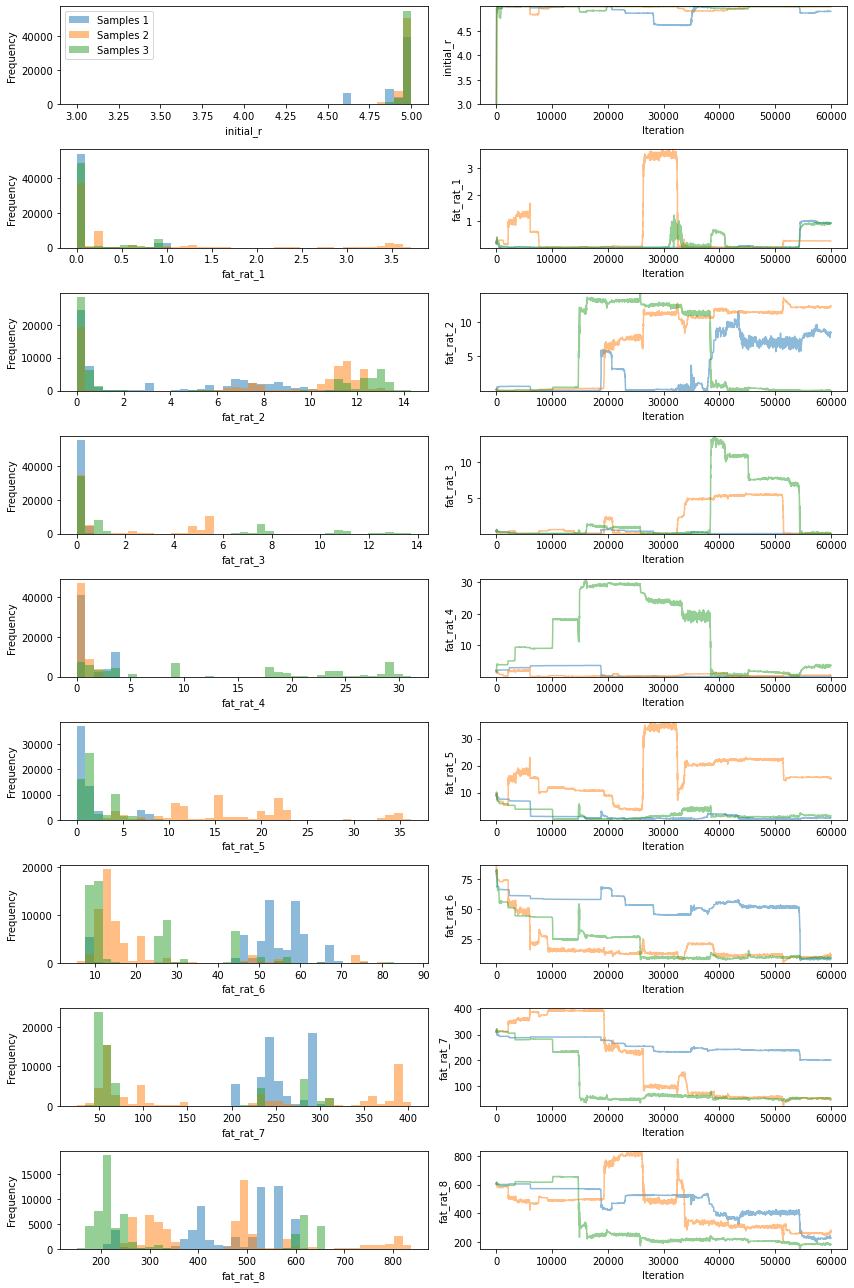

In [10]:
import pints.plot

param_names = ['initial_r']
param_names.extend(['fat_rat_{}'.format(i+1) for i in range(len(age_groups))])

pints.plot.trace(samples, parameter_names=param_names)
plt.show()

In [11]:
samples = samples[:, 30000:, :]

pints.rhat(samples)

array([1.18331266, 1.05515843, 1.84155559, 1.2444559 , 1.50754756,
       3.70012804, 2.18851456, 6.88980444, 1.96014932])

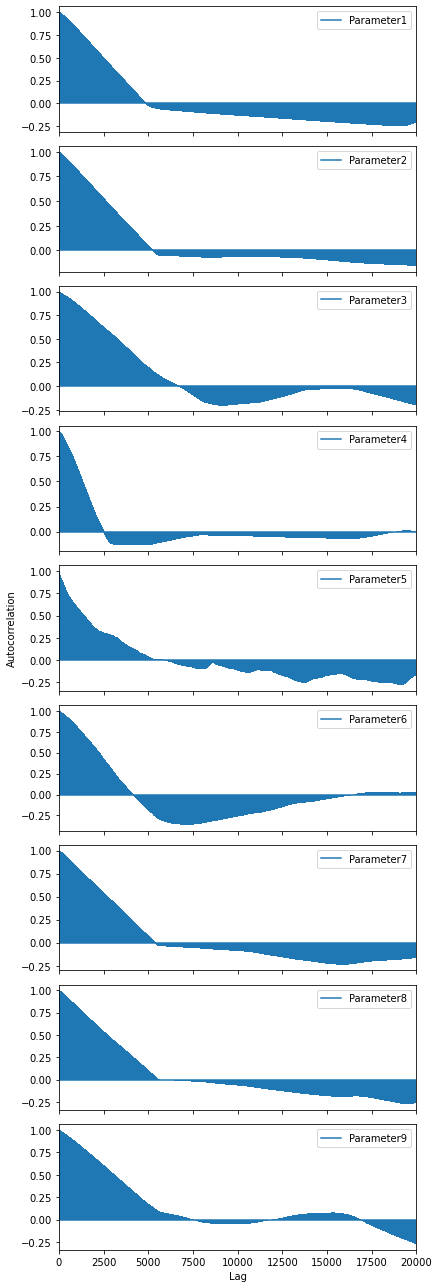

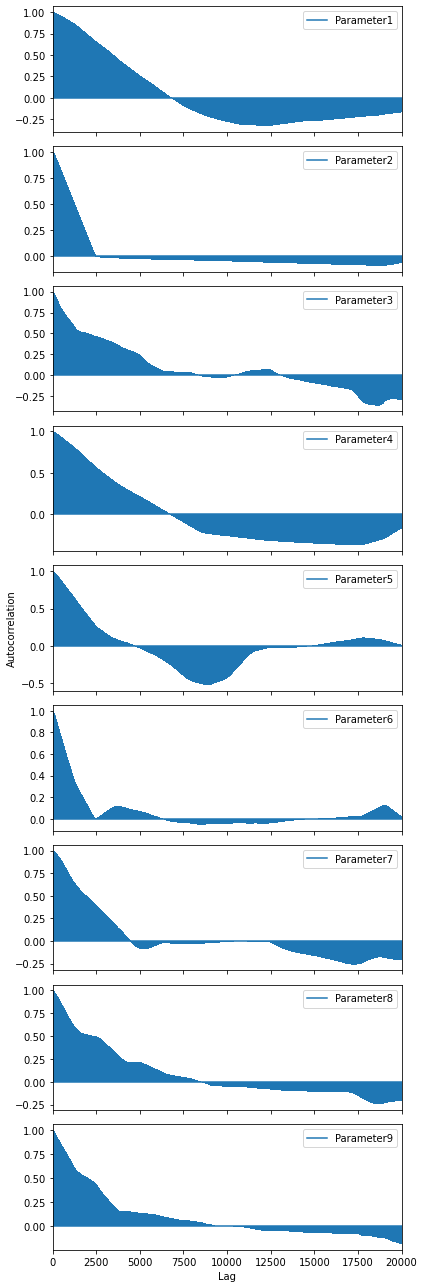

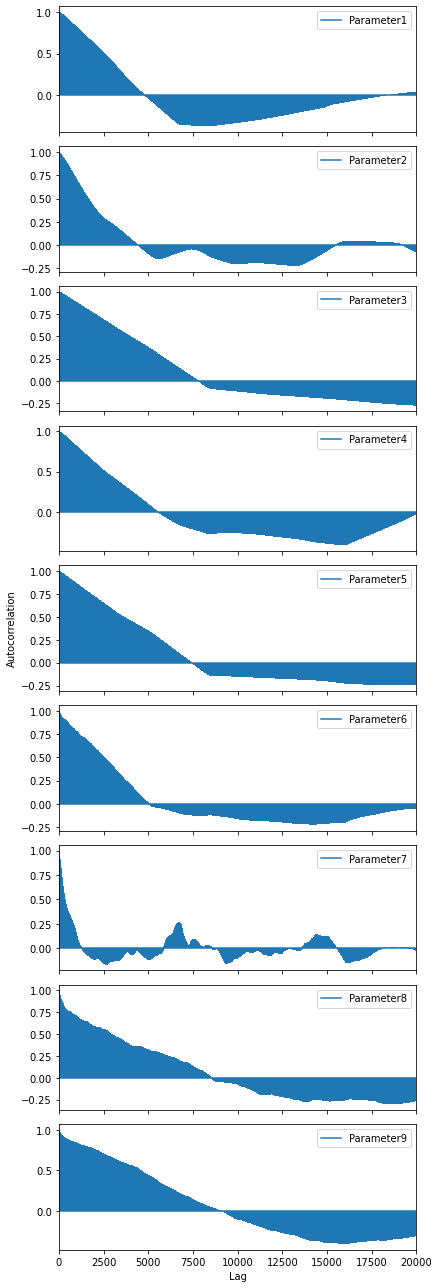

In [12]:
for sample in samples:
    pints.plot.autocorrelation(sample, max_lags=20000)
    plt.show()

### Thin out the MCMC samples (by 10) and run model for the sampled parameter choices to compute the expected number of deaths, new infections and the reproduction number

In [13]:
# Evaluate the model for all parameter sets in the samples
n_chains, n_sample, n_param = samples.shape

extended_samples = np.concatenate((samples[0], samples[1], samples[2]), axis=0)

thinning = max(1, int(n_sample * n_chains / 9000))

n_parameters = model.n_parameters()

predicted_new_infec = []
predicted_deaths = []
predicted_reprod_num = []

# Run model and number of new infections for all regions
for r, _ in enumerate(model.regions):
    reg_predicted_new_infec = []
    reg_predicted_deaths = []
    reg_predicted_reprod_num = []

    parameters[1] = r+1

    for params in extended_samples[::thinning, :n_parameters]:
        parameters[0] = [params[0]] * len(model.regions)
        fatality_ratio = (np.asarray(params[1:]) * 10**(-4)).tolist()

        r_fix = np.empty(len(times))
        model_reg_deaths_data = np.empty(len(times))

        m_fix = em.MultiTimesInfectivity(
            matrices_contact, time_changes_contact, regions, matrices_region, time_changes_region, parameters[0], parameters[10], parameters[2])

        # Run model and number of new infections for all age groups
        model_output = model.simulate(
            parameters=list(deepflatten(parameters, ignore=str)),
            times=times
        )
        age_model_reg_new_infections = model.new_infections(model_output)
        model_reg_new_infections = age_model_reg_new_infections.sum(axis=1)

        for t, time in enumerate(times):
            r_fix[t] = m_fix.compute_reproduction_number(r+1, time, model_output[t, :len(age_groups)])
            model_reg_deaths_data[t] = np.sum(model.mean_deaths(fatality_ratio, time_to_death, t, age_model_reg_new_infections))

        reg_predicted_new_infec.append(model_reg_new_infections)
        reg_predicted_deaths.append(model_reg_deaths_data)
        reg_predicted_reprod_num.append(r_fix)

    reg_predicted_new_infec = np.array(reg_predicted_new_infec)

    predicted_new_infec.append(reg_predicted_new_infec)
    predicted_deaths.append(reg_predicted_deaths)
    predicted_reprod_num.append(reg_predicted_reprod_num)

predicted_new_infec = np.array(predicted_new_infec)
predicted_deaths = np.array(predicted_deaths)
predicted_reprod_num = np.array(predicted_reprod_num)


### Plot the mean and CI bounds of the trajectories of interest

In [14]:
# Set up traces to plot
new_infec_mean = []
deaths_mean = []
reprod_num_mean = []

new_infec_upper = []
deaths_upper = []
reprod_num_upper = []

new_infec_lower = []
deaths_lower = []
reprod_num_lower = []

for r, _ in enumerate(model.regions):
    # Compute the mean 
    new_infec_mean.append(np.mean(predicted_new_infec[r,:,:], axis=0))
    deaths_mean.append(np.mean(predicted_deaths[r,:,:], axis=0))
    reprod_num_mean.append(np.mean(predicted_reprod_num[r,:,:], axis=0))

    # Compute the upper quantiles
    new_infec_upper.append(np.quantile(predicted_new_infec[r,:,:], 0.975, axis=0))
    deaths_upper.append(np.quantile(predicted_deaths[r,:,:], 0.975, axis=0))
    reprod_num_upper.append(np.quantile(predicted_reprod_num[r,:,:], 0.975, axis=0))

    # Compute the lower qunatiles
    new_infec_lower.append(np.quantile(predicted_new_infec[r,:,:], 0.025, axis=0))
    deaths_lower.append(np.quantile(predicted_deaths[r,:,:], 0.025, axis=0))
    reprod_num_lower.append(np.quantile(predicted_reprod_num[r,:,:], 0.025, axis=0))

In [15]:
from plotly.subplots import make_subplots

colours = ['blue', 'red', 'green', 'purple', 'orange', 'black', 'gray', 'pink']

# Group outputs together
outputs = [deaths_data, positives_data]

# Number of regions
n_reg = len(regions)

In [27]:
# Trace names - represent the solver used for the simulation
trace_name = regions
titles = ['Infections', 'Deaths', 'Reproduction Number']

fig = go.Figure()
fig = make_subplots(rows=len(titles), cols=1, subplot_titles=tuple(titles), horizontal_spacing = 0.15)

# Plot (bar chart cases each day)
for r, region in enumerate(regions):
    # Plot of infections
    fig.add_trace(
        go.Scatter(
            x=times,
            y=new_infec_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=new_infec_upper[r].tolist() + new_infec_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 1,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=serology_times,
            y=np.sum(np.multiply(np.nan_to_num(np.divide(positives_data[r], tests[r])), susceptibles[r]), axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 1,
        col= 1
    )

    # Plot deaths
    fig.add_trace(
        go.Scatter(
            x=times,
            y=deaths_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=deaths_upper[r].tolist() + deaths_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 2,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=deaths_times,
            y=np.sum(deaths_data[r], axis=1).tolist(),
            mode='markers',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 2,
        col= 1
    )

    # Plot reproduction number
    fig.add_trace(
        go.Scatter(
            x=times,
            y=reprod_num_mean[r].tolist(),
            mode='lines',
            name=trace_name[r],
            showlegend=False,
            line_color=colours[r]
        ),
        row= 3,
        col= 1
    )

    fig.add_trace(
        go.Scatter(
            x=times + times[::-1],
            y=reprod_num_upper[r].tolist() + reprod_num_lower[r].tolist()[::-1],
            fill='toself',
            fillcolor=colours[r],
            line_color=colours[r],
            opacity=0.15,
            mode='lines',
            showlegend=False,
            name=trace_name[r]
        ),
        row= 3,
        col= 1
    )

# Add axis labels
fig.update_layout(
    width=600, 
    height=900,
    plot_bgcolor='white',
    xaxis=dict(
        linecolor='black',
        tickvals=np.arange(1, 93, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29', 'May 09', 'May 19', 'May 29']),
    yaxis=dict(linecolor='black'),
    xaxis2=dict(
        linecolor='black',
        tickvals=np.arange(1, 93, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29', 'May 09', 'May 19', 'May 29']),
    yaxis2=dict(linecolor='black'),
    xaxis3=dict(
        linecolor='black',
        tickvals=np.arange(1, 93, 10).tolist(),
        ticktext=['Mar 01', 'Mar 11', 'Mar 21', 'Mar 31', 'Apr 09', 'Apr 19', 'Apr 29', 'May 09', 'May 19', 'May 29']),
    yaxis3=dict(linecolor='black'),
    legend=dict(
        orientation='h',
        yanchor="bottom",
        y=1.075,
        xanchor="right",
        x=1)
    )

fig.write_image('images/Figure-2.pdf')
fig.show()

<ipython-input-27-0e6028dd587e>:42: RuntimeWarning:

invalid value encountered in true_divide

